In [0]:
from utils import *

In [0]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import torch.optim as optim

In [0]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [0]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)

In [0]:
batch_size = 60
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                 dataset=test_set,
                 batch_size=batch_size,
                 shuffle=False)

In [0]:
class Lenet_300_100(nn.Module):
  def __init__(self):
    super(Lenet_300_100, self).__init__()
    self.fc1 = create_maskable_module(nn.Linear(28 * 28, 300))
    self.relu1 = nn.ReLU(inplace = True)
    
    self.fc2 = create_maskable_module(nn.Linear(300, 100))
    self.relu2 = nn.ReLU(inplace = True)
    
    self.fc3 = create_maskable_module(nn.Linear(100, 10))
    
    self.init_params = self.state_dict()
    
  def forward(self, x):
    x = x.view(x.size(0), 28 * 28)
    out = self.fc1(x)
    out = self.relu1(out)
    out = self.fc2(out)
    out = self.relu2(out)
    logits = self.fc3(out)
    
    return logits 
  
  def set_masks(self, masks):
    self.fc1.set_mask(masks[0])
    self.fc2.set_mask(masks[1])
    self.fc3.set_mask(masks[2])
    
  def reset_parameters(self):
    self.load_state_dict(self.init_params)
    
  def init_parameters(self):
    for name in self.init_params.keys():
      yield self.init_params[name]
        

In [11]:
%%time
net = Lenet_300_100()

if torch.cuda.is_available():
    print('CUDA enabled.')
    net.cuda()


# Retrain
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1.2e-3,
                            weight_decay=0.0001)

history = train_one_shot(net, criterion, optimizer, 
                         prepare_epochs=15, prune_epochs=15,
                         prune_percent=75, train_loader=train_loader,
                         val_loader=test_loader)

print("--- After retraining ---")
print("Accuracy: {}".format(compute_accuracy(net, test_loader)))

CUDA enabled.
Preparing: Train before prune
Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Pruning...
Layer 1 | Linear layer | 78.88% parameters pruned
Layer 2 | Linear layer | 46.44% parameters pruned
Layer 3 | Linear layer | 18.90% parameters pruned
Current pruning rate: 74.88%
Train after prune
Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
--- After retraining ---
Accuracy: 0.8867
CPU times: user 5min 44s, sys: 7.89 s, total: 5min 52s
Wall time: 5min 55s


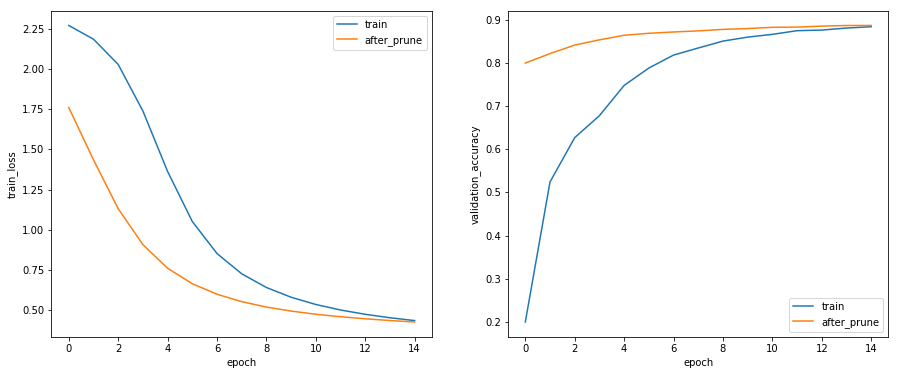

In [12]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(['train_loss', 'validation_accuracy']):
  plt.subplot(1, 2, i+1)
  for stage in ['train', 'after_prune']:
    plt.plot(history[stage][key], label=stage)
  plt.ylabel(key)
  plt.xlabel('epoch')
  plt.legend()

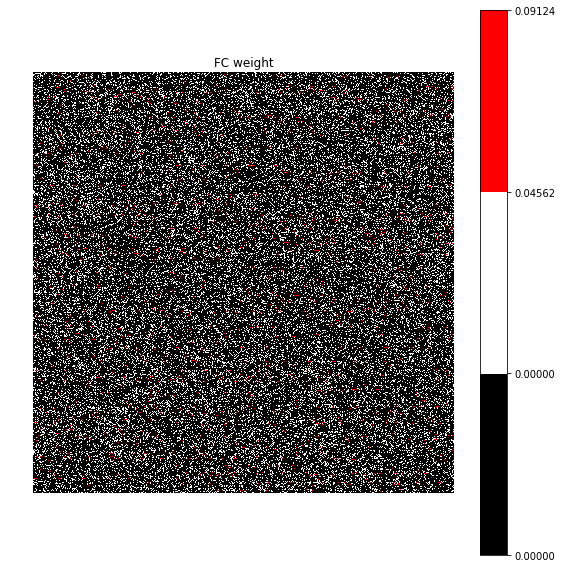

In [13]:
visualize(net.fc1.weight,'FC weight', (8, 8))